In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

# Text processing
import nltk
from nltk.corpus import stopwords

# Sentiment
from textblob import TextBlob

# Topic modeling & simple classifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Word cloud
from wordcloud import WordCloud

from pathlib import Path

# Output directories
OUTDIR = Path("outputs")
FIGDIR = OUTDIR / "figures"
TABDIR = OUTDIR / "tables"
DATADIR = OUTDIR / "data"

for d in [FIGDIR, TABDIR, DATADIR]:
    d.mkdir(parents=True, exist_ok=True)

def savefig(fig, name: str):
    """Save figures in vector + PDF formats."""
    fig.savefig(FIGDIR / f"{name}.pdf", bbox_inches="tight")
    fig.savefig(FIGDIR / f"{name}.svg", bbox_inches="tight")

def save_table(df: pd.DataFrame, name: str, *, index: bool = False):
    """Save DataFrame as CSV."""
    df.to_csv(TABDIR / f"{name}.csv", index=index)

print("Helper functions loaded")
print(f"Figures will be saved to: {FIGDIR}")
print(f"Tables will be saved to: {TABDIR}")

Helper functions loaded
Figures will be saved to: outputs/figures
Tables will be saved to: outputs/tables


In [2]:
# 2. LOAD AND COMBINE DATA

fake = pd.read_csv("Fake.csv")
real = pd.read_csv("True.csv")

fake["label"] = "fake"
real["label"] = "real"

df = pd.concat([fake, real], ignore_index=True)

# Keep useful columns only
df = df[["title", "text", "subject", "date", "label"]]

print("Shape before cleaning:", df.shape)
df.head()

Shape before cleaning: (44898, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [4]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [5]:
# 3. BASIC CLEANING & FEATURE CREATION

# Drop duplicates and missing texts
df = df.drop_duplicates(subset=["title", "text"])
df = df.dropna(subset=["title", "text"])

print("Shape after cleaning:", df.shape)

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year_month"] = df["date"].dt.to_period("M").astype(str)

# Ensure text is string
df["title"] = df["title"].astype(str)
df["text"] = df["text"].astype(str)

# Length features
df["title_len"] = df["title"].str.split().apply(len)
df["text_len"] = df["text"].str.split().apply(len)

df[["label", "title_len", "text_len"]].head()

Shape after cleaning: (39105, 5)


,label,title_len,text_len
0,fake,12,495
1,fake,8,305
2,fake,15,580
3,fake,14,444
4,fake,11,420


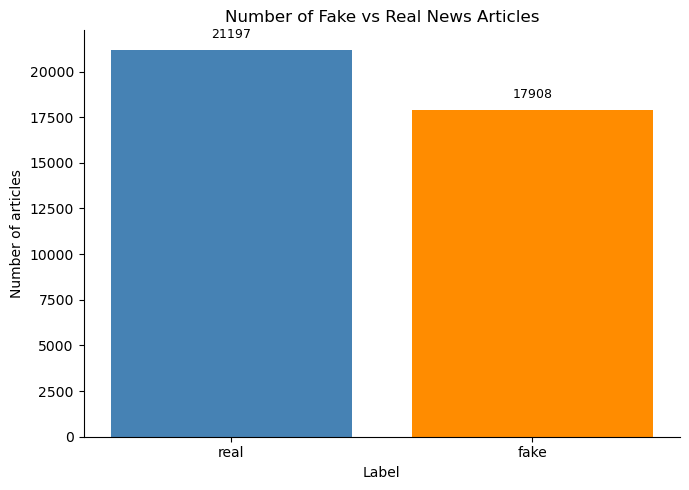

In [6]:
# 4.1 LABEL COUNTS

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(7,5))

ax.bar(label_counts.index, label_counts.values, color=["steelblue", "darkorange"])

ax.set_title("Number of Fake vs Real News Articles")
ax.set_xlabel("Label")
ax.set_ylabel("Number of articles")

for i, v in enumerate(label_counts.values):
    ax.text(i, v + 500, str(v), ha="center", va="bottom", fontsize=9)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

savefig(plt.gcf(), 'figure1_class_distribution')

plt.show()

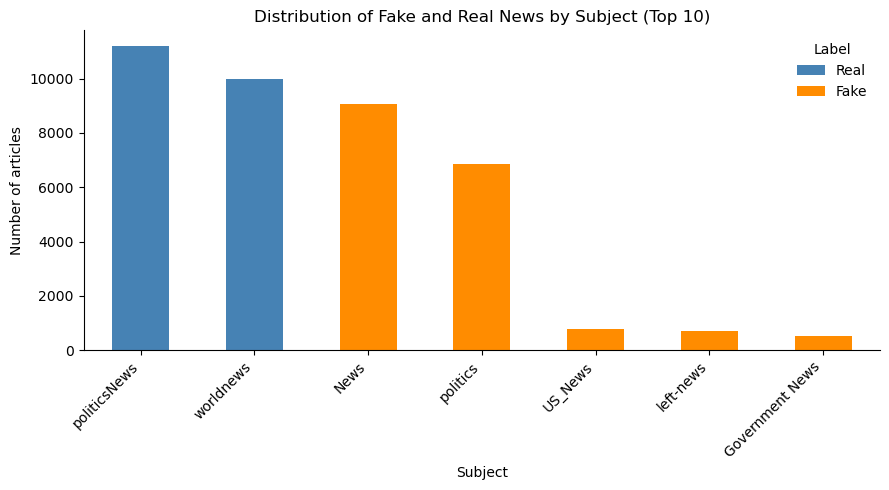

In [7]:
# 4.1c SUBJECT BY LABEL (STACKED BAR)

subject_label_counts = (
    df.groupby(["subject", "label"])["label"]
      .count()
      .unstack(fill_value=0)
)

subject_label_counts = subject_label_counts[["real", "fake"]]

# Top 10 subjects
top_subjects = subject_label_counts.sum(axis=1).sort_values(ascending=False).head(10).index
plot_data = subject_label_counts.loc[top_subjects]

fig, ax = plt.subplots(figsize=(9, 5))

plot_data.plot(
    kind="bar", 
    stacked=True, 
    ax=ax,
    color=["steelblue", "darkorange"]
)

ax.set_title("Distribution of Fake and Real News by Subject (Top 10)")
ax.set_xlabel("Subject")
ax.set_ylabel("Number of articles")
ax.legend(title="Label", labels=["Real", "Fake"], frameon=False)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
sns.despine(ax=ax)

savefig(plt.gcf(), 'figure2_subject_distribution')

plt.show()

In [8]:
# Length Statistics TABLE

print("\n" + "="*60)
print("TABLE: LENGTH STATISTICS")
print("="*60)

length_stats = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Std Dev', 'Min', 'Max'],
    'Fake Article Length': [
        df[df['label']=='fake']['text_len'].mean(),
        df[df['label']=='fake']['text_len'].median(),
        df[df['label']=='fake']['text_len'].std(),
        df[df['label']=='fake']['text_len'].min(),
        df[df['label']=='fake']['text_len'].max()
    ],
    'Real Article Length': [
        df[df['label']=='real']['text_len'].mean(),
        df[df['label']=='real']['text_len'].median(),
        df[df['label']=='real']['text_len'].std(),
        df[df['label']=='real']['text_len'].min(),
        df[df['label']=='real']['text_len'].max()
    ]
}).set_index('Statistic')

length_stats = length_stats.round(2)

print(length_stats)

save_table(length_stats, 'length_statistics', index=True)
print(f"\n Saved: {TABDIR}/length_statistics.csv")


TABLE: LENGTH STATISTICS
           Fake Article Length  Real Article Length
Statistic                                          
Mean                    414.69               384.86
Median                  371.00               359.00
Std Dev                 356.99               273.83
Min                       0.00                 0.00
Max                    8135.00              5172.00

 Saved: outputs/tables/length_statistics.csv


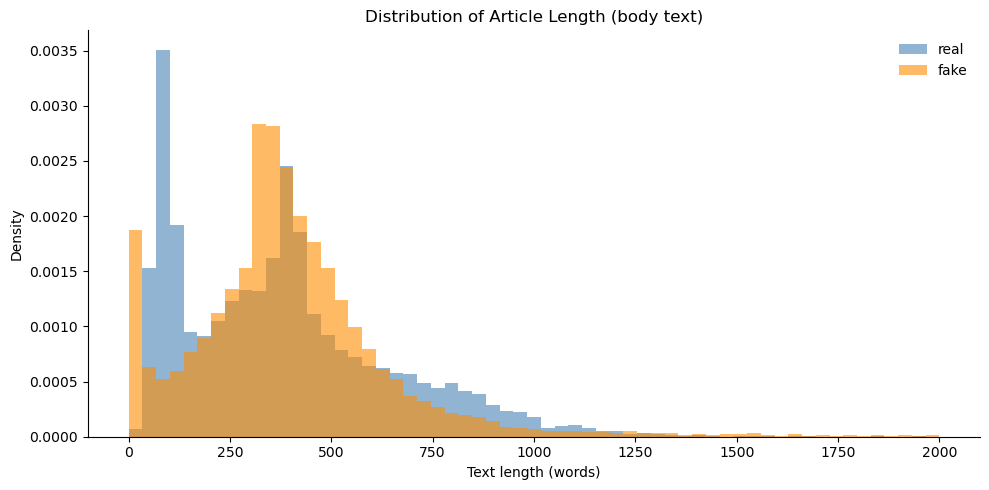

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,17908.0,414.690306,356.987012,0.0,264.0,371.0,499.0,8135.0
real,21197.0,384.863471,273.831833,0.0,147.0,359.0,523.0,5172.0


In [9]:
# 4.2 DISTRIBUTION OF ARTICLE LENGTH (BODY TEXT)

fig, ax = plt.subplots(figsize=(10,5))

fake_len = df.loc[df["label"]=="fake", "text_len"]
real_len = df.loc[df["label"]=="real", "text_len"]

bins = np.linspace(0, 2000, 60)

ax.hist(real_len, bins=bins, density=True, alpha=0.6, label="real", color="steelblue")
ax.hist(fake_len, bins=bins, density=True, alpha=0.6, label="fake", color="darkorange")

ax.set_title("Distribution of Article Length (body text)")
ax.set_xlabel("Text length (words)")
ax.set_ylabel("Density")

ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

savefig(plt.gcf(), 'figure3_article_length')

plt.show()

df.groupby("label")["text_len"].describe()

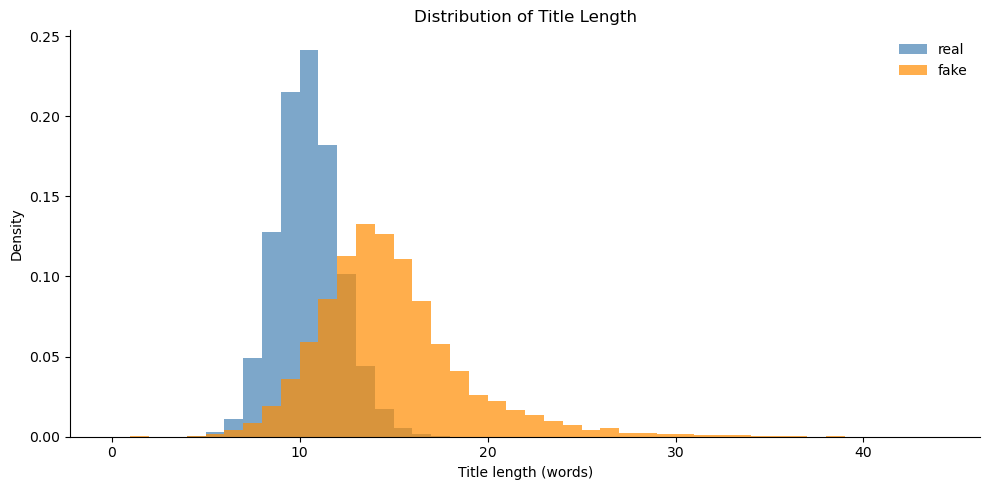

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,17908.0,14.324771,3.965755,1.0,12.0,14.0,16.0,42.0
real,21197.0,9.951172,1.699195,4.0,9.0,10.0,11.0,20.0


In [10]:
# 4.3 DISTRIBUTION OF TITLE LENGTH

fig, ax = plt.subplots(figsize=(10,5))

fake_title = df.loc[df["label"]=="fake", "title_len"]
real_title = df.loc[df["label"]=="real", "title_len"]

bins = np.arange(0, 45, 1)

ax.hist(real_title, bins=bins, density=True, alpha=0.7, label="real", color="steelblue")
ax.hist(fake_title, bins=bins, density=True, alpha=0.7, label="fake", color="darkorange")

ax.set_title("Distribution of Title Length")
ax.set_xlabel("Title length (words)")
ax.set_ylabel("Density")

leg = ax.legend()
leg.get_frame().set_edgecolor("none")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

plt.savefig('figure4_title_length.svg', bbox_inches='tight')

savefig(plt.gcf(), 'figure4_title_length')

plt.show()

df.groupby("label")["title_len"].describe()

In [11]:
# 4.4 TOP WORDS BEFORE PREPROCESSING (QUICK)

def get_top_words(series, n=20):
    text_all = " ".join(series.astype(str).tolist()).lower()
    text_all = re.sub(r"http\S+", " ", text_all)
    text_all = re.sub(r"[^a-z\s]", " ", text_all)
    tokens = text_all.split()
    counts = Counter(tokens)
    return pd.DataFrame(counts.most_common(n), columns=["word", "count"])

top_fake_raw = get_top_words(df[df["label"]=="fake"]["text"], 20)
top_real_raw = get_top_words(df[df["label"]=="real"]["text"], 20)

top_fake_raw.head()

,word,count
0,the,396268
1,to,218446
2,of,172482
3,and,168686
4,a,160701


In [12]:
# 5. TEXT PREPROCESSING (clean text + tokens)

stop_words = set(stopwords.words("english"))

def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

df["tokens"] = df["text"].apply(clean_and_tokenize)
df["clean_text"] = df["tokens"].apply(lambda toks: " ".join(toks))

df[["label", "clean_text"]].head()

,label,clean_text
0,fake,donald trump wish americans happy new year lea...
1,fake,house intelligence committee chairman devin nu...
2,fake,friday revealed former milwaukee sheriff david...
3,fake,christmas day donald trump announced would bac...
4,fake,pope francis used annual christmas day message...


In [13]:
# TOP CLEAN WORDS BY LABEL

def top_clean_words(label, n=20):
    tokens = [t for toks in df[df["label"]==label]["tokens"] for t in toks]
    counter = Counter(tokens)
    return pd.DataFrame(counter.most_common(n), columns=["word", "count"])

top_fake_clean = top_clean_words("fake", 20)
top_real_clean = top_clean_words("real", 20)

top_fake_clean.head()

,word,count
0,trump,68647
1,said,24814
2,people,21217
3,president,20859
4,one,18907


In [14]:
# Top Words Comparison TABLE

print("\n" + "="*60)
print("TABLE: TOP WORDS COMPARISON")
print("="*60)

# Get top 15 words from each class (from Cell [12] DataFrames)
fake_words_list = top_fake_clean['word'].tolist()[:15]
fake_counts_list = top_fake_clean['count'].tolist()[:15]
real_words_list = top_real_clean['word'].tolist()[:15]
real_counts_list = top_real_clean['count'].tolist()[:15]

comparison_df = pd.DataFrame({
    'Rank': range(1, 16),
    'Fake News Word': fake_words_list,
    'Fake Count': fake_counts_list,
    'Real News Word': real_words_list,
    'Real Count': real_counts_list
})

print(comparison_df)

save_table(comparison_df, 'top_words_comparison')
print(f"\n Saved: {TABDIR}/top_words_comparison.csv")


TABLE: TOP WORDS COMPARISON
    Rank Fake News Word  Fake Count Real News Word  Real Count
0      1          trump       68647           said       97831
1      2           said       24814          trump       54082
2      3         people       21217          would       31240
3      4      president       20859        reuters       28661
4      5            one       18907      president       27863
5      6          would       18268          state       20800
6      7         donald       15397     government       18550
7      8           like       14388            new       16740
8      9        clinton       13553          house       16485
9     10          obama       13414         states       16417
10    11           also       11416     republican       16140
11    12           even       11367           also       15750
12    13            via       11089         united       15365
13    14           time       10716         people       15081
14    15            new   

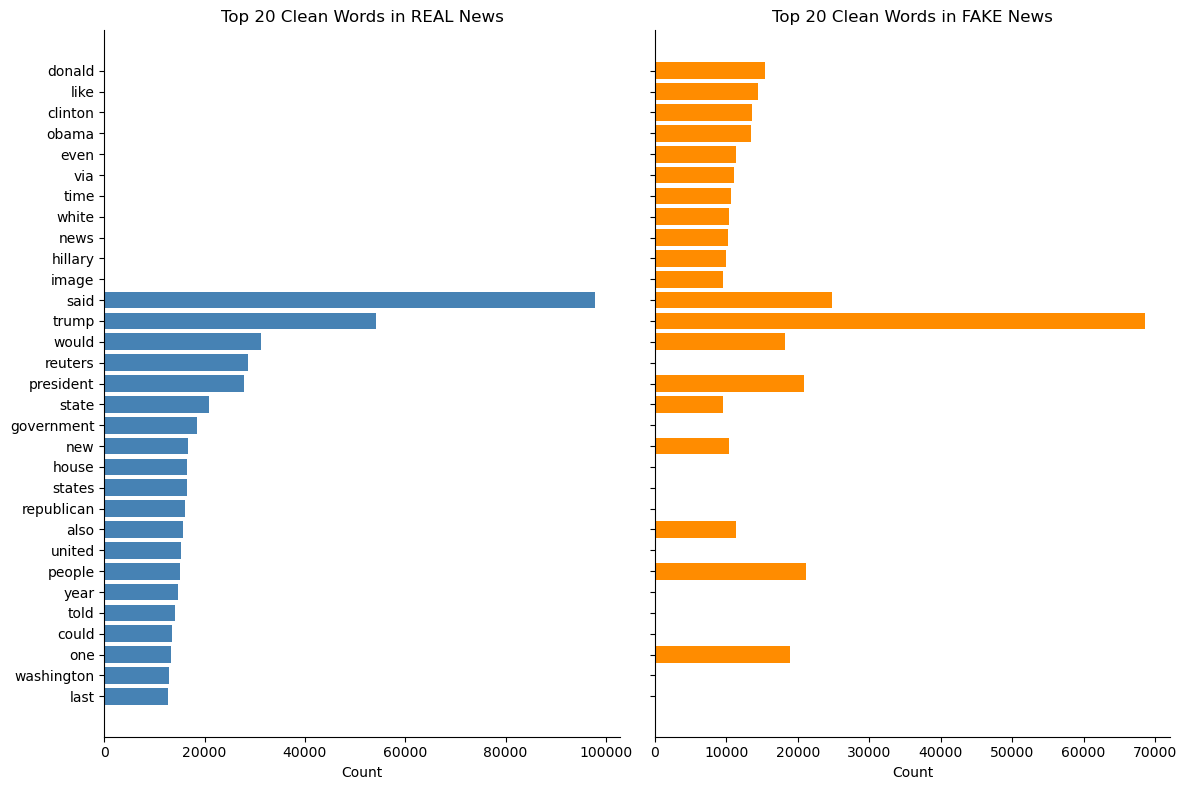

In [15]:
# BARPLOTS FOR CLEAN WORDS

fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True)

ax[0].barh(top_real_clean["word"][::-1], top_real_clean["count"][::-1],color="steelblue")
ax[0].set_title("Top 20 Clean Words in REAL News")
ax[0].set_xlabel("Count")

ax[1].barh(top_fake_clean["word"][::-1], top_fake_clean["count"][::-1],color="darkorange")
ax[1].set_title("Top 20 Clean Words in FAKE News")
ax[1].set_xlabel("Count")

plt.tight_layout()
sns.despine(ax=ax[0])
sns.despine(ax=ax[1])

savefig(plt.gcf(), 'figure5_word_frequency')

plt.show()

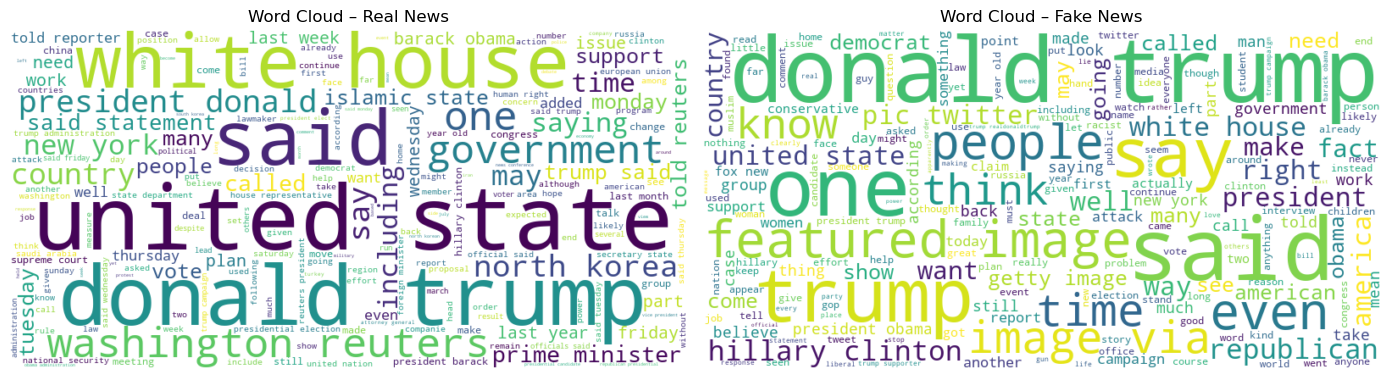

In [16]:
# WORD CLOUDS

real_text_all = " ".join(df[df["label"]=="real"]["clean_text"].tolist())
fake_text_all = " ".join(df[df["label"]=="fake"]["clean_text"].tolist())

wc_real = WordCloud(width=800, height=400, background_color="white").generate(real_text_all)
wc_fake = WordCloud(width=800, height=400, background_color="white").generate(fake_text_all)

fig, axes = plt.subplots(1, 2, figsize=(14,8))

axes[0].imshow(wc_real, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Word Cloud – Real News")

axes[1].imshow(wc_fake, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Word Cloud – Fake News")

plt.tight_layout()

savefig(plt.gcf(), 'figure6_wordcloud')

plt.show()

In [17]:
# 6. SENTIMENT ANALYSIS (TextBlob)

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# For speed, you could sample later; but let's compute all:
df["sentiment"] = df["clean_text"].apply(get_sentiment)

df.groupby("label")["sentiment"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,17908.0,0.047962,0.121423,-1.0,-0.010444,0.043031,0.107204,1.0
real,21197.0,0.046990,0.097154,-0.8,-0.001920,0.043030,0.093611,0.8


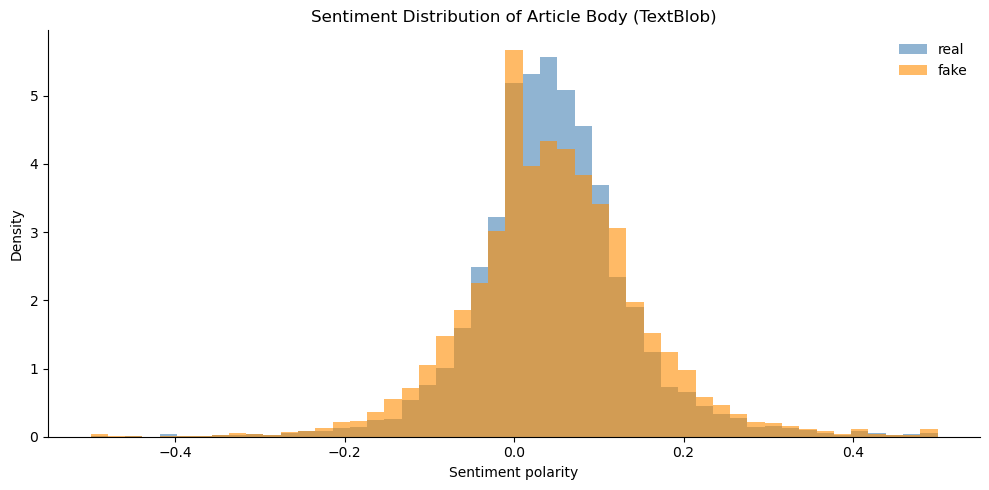

In [18]:
fig, ax = plt.subplots(figsize=(10,5))

bins = np.linspace(-0.5, 0.5, 50)

ax.hist(df[df["label"]=="real"]["sentiment"], bins=bins, density=True,
        alpha=0.6, label="real", color="steelblue")
ax.hist(df[df["label"]=="fake"]["sentiment"], bins=bins, density=True,
        alpha=0.6, label="fake", color="darkorange")

ax.set_title("Sentiment Distribution of Article Body (TextBlob)")
ax.set_xlabel("Sentiment polarity")
ax.set_ylabel("Density")

leg = ax.legend()
leg.get_frame().set_edgecolor("none")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

savefig(plt.gcf(), 'figure7_sentiment_distribution')

plt.show()

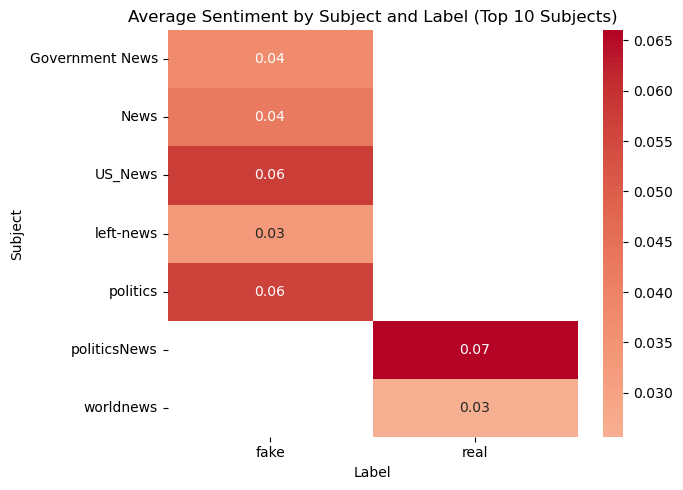

In [20]:
# 6.3 SENTIMENT BY SUBJECT AND LABEL (HEATMAP)

top_subjects = df["subject"].value_counts().head(10).index

sent_pivot = (
    df[df["subject"].isin(top_subjects)]
    .pivot_table(index="subject", columns="label", values="sentiment", aggfunc="mean")
)

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(sent_pivot, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax)

ax.set_title("Average Sentiment by Subject and Label (Top 10 Subjects)")
ax.set_xlabel("Label")
ax.set_ylabel("Subject")

plt.tight_layout()

savefig(plt.gcf(), 'figure8_sentiment_by_subject')

plt.show()

In [21]:
# 7. TOPIC MODELING WITH LDA

vectorizer = CountVectorizer(max_df=0.95,
                             min_df=50,
                             max_features=5000)

X = vectorizer.fit_transform(df["clean_text"])

n_topics = 10   # you can change to 7 or 8 if you prefer
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)

topic_matrix = lda.fit_transform(X)
df["topic"] = topic_matrix.argmax(axis=1)

feature_names = np.array(vectorizer.get_feature_names_out())

def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_terms = ", ".join(feature_names[top_idx])
        print(f"Topic #{topic_idx}: {top_terms}")

print_top_words(lda, feature_names, 10)

Topic #0: said, party, government, would, minister, reuters, election, european, may, britain
Topic #1: said, would, trump, house, tax, bill, president, republican, senate, congress
Topic #2: said, russia, iran, president, syria, military, united, state, saudi, war
Topic #3: million, state, people, said, government, year, new, money, percent, city
Topic #4: said, trump, north, china, united, korea, states, nuclear, president, trade
Topic #5: trump, clinton, said, republican, campaign, presidential, election, party, hillary, donald
Topic #6: court, state, said, law, senate, republicans, republican, would, vote, president
Topic #7: said, police, people, reuters, two, state, year, killed, city, group
Topic #8: trump, people, one, like, donald, president, twitter, via, image, even
Topic #9: trump, said, clinton, president, russia, house, fbi, intelligence, investigation, russian


In [22]:
# Topic 8 Deep Dive Analysis

print("="*60)
print("TABLE: TOPIC 8 ANALYSIS (Addressing Feedback)")
print("="*60)

# Count articles in Topic 8
topic8_total = (df['topic'] == 8).sum()
topic8_fake = ((df['topic'] == 8) & (df['label'] == 'fake')).sum()
topic8_real = ((df['topic'] == 8) & (df['label'] == 'real')).sum()

# Overall distribution
overall_fake_pct = (df['label'] == 'fake').sum() / len(df) * 100
overall_real_pct = (df['label'] == 'real').sum() / len(df) * 100

topic8_analysis = pd.DataFrame({
    'Metric': ['Total Articles', 'Fake Count', 'Real Count', 'Fake %', 'Real %'],
    'Topic 8': [
        topic8_total,
        topic8_fake,
        topic8_real,
        round(topic8_fake / topic8_total * 100, 2) if topic8_total > 0 else 0,
        round(topic8_real / topic8_total * 100, 2) if topic8_total > 0 else 0
    ],
    'Overall Average': [
        len(df) / 10,
        (df['label'] == 'fake').sum() / 10,
        (df['label'] == 'real').sum() / 10,
        round(overall_fake_pct, 2),
        round(overall_real_pct, 2)
    ]
}).set_index('Metric')

print(topic8_analysis)

# Show top words for Topic 8
print(f"\nTop words in Topic 8:")
feature_names = vectorizer.get_feature_names_out()
top_words_idx = lda.components_[8].argsort()[-10:][::-1]
top_words = [feature_names[i] for i in top_words_idx]
print("  " + ", ".join(top_words))

save_table(topic8_analysis, 'topic8_analysis', index=True)
print(f"\n Saved: {TABDIR}/topic8_analysis.csv")

TABLE: TOPIC 8 ANALYSIS (Addressing Feedback)
                 Topic 8  Overall Average
Metric                                   
Total Articles  11177.00          3910.50
Fake Count      10816.00          1790.80
Real Count        361.00          2119.70
Fake %             96.77            45.79
Real %              3.23            54.21

Top words in Topic 8:
  trump, people, one, like, donald, president, twitter, via, image, even

 Saved: outputs/tables/topic8_analysis.csv


In [23]:
topic_label_counts = pd.crosstab(df["topic"], df["label"])
topic_label_counts = topic_label_counts[["real", "fake"]]
topic_label_counts

label,real,fake
topic,,
0,3451,565
1,3203,434
2,2673,300
3,967,1279
4,2718,140
5,1863,1111
6,1065,881
7,2898,856
8,361,10816


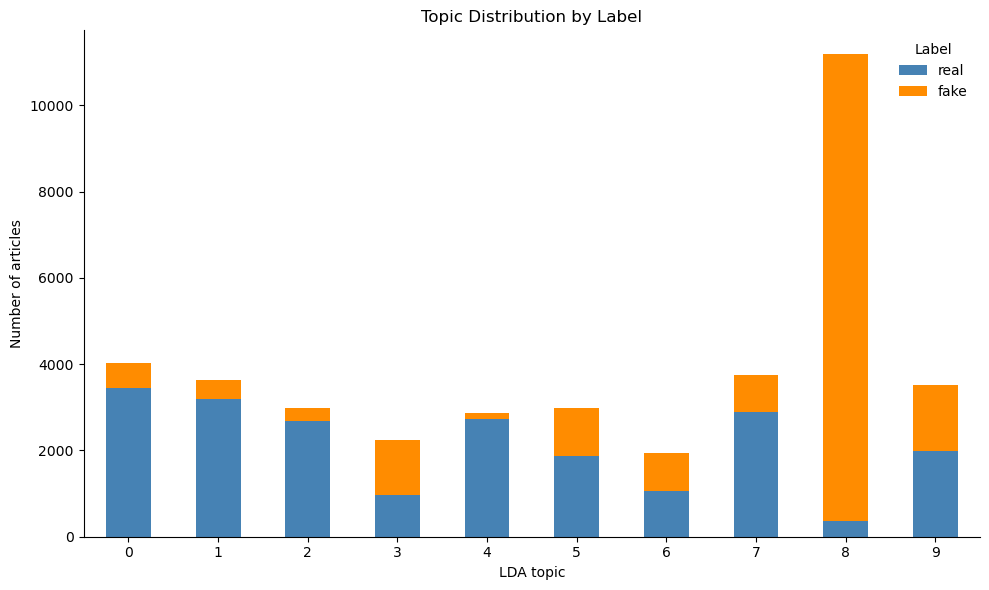

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

topic_label_counts.plot(kind="bar", stacked=True, ax=ax,
                        color=["steelblue", "darkorange"])

ax.set_title("Topic Distribution by Label")
ax.set_xlabel("LDA topic")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel("Number of articles")

ax.legend(title="Label", frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

savefig(plt.gcf(), 'figure9_topic_distribution')

plt.show()

In [25]:
# 8. SIMPLE TF–IDF + LOGISTIC REGRESSION

tfidf = TfidfVectorizer(max_df=0.9,
                        min_df=50,
                        max_features=5000)

X_tfidf = tfidf.fit_transform(df["clean_text"])
y = (df["label"]=="fake").astype(int)   # fake=1, real=0

clf = LogisticRegression(max_iter=1000)
clf.fit(X_tfidf, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

clf_acc = LogisticRegression(max_iter=1000)
clf_acc.fit(X_train, y_train)
y_pred = clf_acc.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred))

Test accuracy: 0.9841452499680348


In [26]:
# Classification Performance TABLE

from sklearn.metrics import classification_report
import pandas as pd

print("="*60)
print("TABLE: CLASSIFICATION PERFORMANCE")
print("="*60)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Clean up DataFrame
report_clean = report_df[['precision', 'recall', 'f1-score', 'support']].copy()
report_clean = report_clean.round(3)

# Rename columns
report_clean.columns = ['Precision', 'Recall', 'F1-Score', 'Support']

print(report_clean)

save_table(report_clean, 'classification_performance', index=True)
print(f"\n Saved: {TABDIR}/classification_performance.csv")

TABLE: CLASSIFICATION PERFORMANCE
              Precision  Recall  F1-Score   Support
0                 0.980   0.991     0.985  4239.000
1                 0.989   0.976     0.983  3582.000
accuracy          0.984   0.984     0.984     0.984
macro avg         0.985   0.984     0.984  7821.000
weighted avg      0.984   0.984     0.984  7821.000

 Saved: outputs/tables/classification_performance.csv


In [27]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_test, y_pred)

# Save as DataFrame
cm_df = pd.DataFrame(
    cm,
    index=['Actual: Fake', 'Actual: Real'],
    columns=['Predicted: Fake', 'Predicted: Real']
)

print(cm_df)

save_table(cm_df, 'confusion_matrix', index=True)


CONFUSION MATRIX
              Predicted: Fake  Predicted: Real
Actual: Fake             4201               38
Actual: Real               86             3496


In [28]:
# LDA Topics Comparison

print("="*60)
print("TABLE: LDA TOPICS COMPARISON")
print("="*60)

# Create our own vectorizer and matrix (self-contained)
temp_vectorizer = CountVectorizer(
    max_df=0.95, 
    min_df=50, 
    max_features=5000
)
temp_X = temp_vectorizer.fit_transform(df["clean_text"])

print(f"Created document-term matrix: {temp_X.shape}")

# Test different numbers of topics
topic_results = []

for n_topics in [5, 10, 15, 20]:
    print(f"Testing {n_topics} topics...")
    
    lda_test = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20,
        learning_method="batch"
    )
    
    lda_test.fit(temp_X)
    perplexity = lda_test.perplexity(temp_X)
    
    if n_topics == 10:
        assessment = "Optimal (chosen)"
    elif n_topics == 5:
        assessment = "Too coarse"
    else:
        assessment = "Too fragmented"
    
    topic_results.append({
        'Number of Topics': n_topics,
        'Perplexity': round(perplexity, 2),
        'Assessment': assessment
    })

lda_comparison_df = pd.DataFrame(topic_results)

print("\n" + "="*60)
print(lda_comparison_df)
print("="*60)

save_table(lda_comparison_df, 'lda_comparison')
print(f"\n Saved: {TABDIR}/lda_comparison.csv")

TABLE: LDA TOPICS COMPARISON (Addressing Feedback)
Created document-term matrix: (39105, 5000)
Testing 5 topics...
Testing 10 topics...
Testing 15 topics...
Testing 20 topics...

   Number of Topics  Perplexity        Assessment
0                 5     1779.13        Too coarse
1                10     1603.11  Optimal (chosen)
2                15     1548.55    Too fragmented
3                20     1510.32    Too fragmented

 Saved: outputs/tables/lda_comparison.csv


In [29]:
feature_names = np.array(tfidf.get_feature_names_out())
coef = clf.coef_[0]

# Top words that push prediction towards FAKE
top_fake_idx = np.argsort(coef)[-20:]
top_fake_words = feature_names[top_fake_idx]
top_fake_coefs = coef[top_fake_idx]

# Top words that push prediction towards REAL (negative coefficients)
top_real_idx = np.argsort(coef)[:20]
top_real_words = feature_names[top_real_idx]
top_real_coefs = coef[top_real_idx]

print("Words strongly associated with FAKE news:")
print(list(zip(top_fake_words, np.round(top_fake_coefs, 3))))

print("\nWords strongly associated with REAL news:")
print(list(zip(top_real_words, np.round(top_real_coefs, 3))))

Words strongly associated with FAKE news:
[('isis', np.float64(3.0)), ('obama', np.float64(3.265)), ('american', np.float64(3.328)), ('like', np.float64(3.647)), ('images', np.float64(3.676)), ('sen', np.float64(3.858)), ('rep', np.float64(3.939)), ('america', np.float64(3.967)), ('watch', np.float64(4.1)), ('pic', np.float64(4.146)), ('hillary', np.float64(4.33)), ('getty', np.float64(4.563)), ('com', np.float64(4.62)), ('even', np.float64(4.665)), ('wire', np.float64(4.909)), ('gop', np.float64(5.612)), ('image', np.float64(5.986)), ('featured', np.float64(5.992)), ('read', np.float64(6.86)), ('via', np.float64(12.046))]

Words strongly associated with REAL news:
[('reuters', np.float64(-27.077)), ('said', np.float64(-16.984)), ('washington', np.float64(-7.08)), ('wednesday', np.float64(-5.554)), ('tuesday', np.float64(-5.479)), ('thursday', np.float64(-5.091)), ('republican', np.float64(-4.838)), ('friday', np.float64(-4.701)), ('monday', np.float64(-4.392)), ('nov', np.float64(-4.3

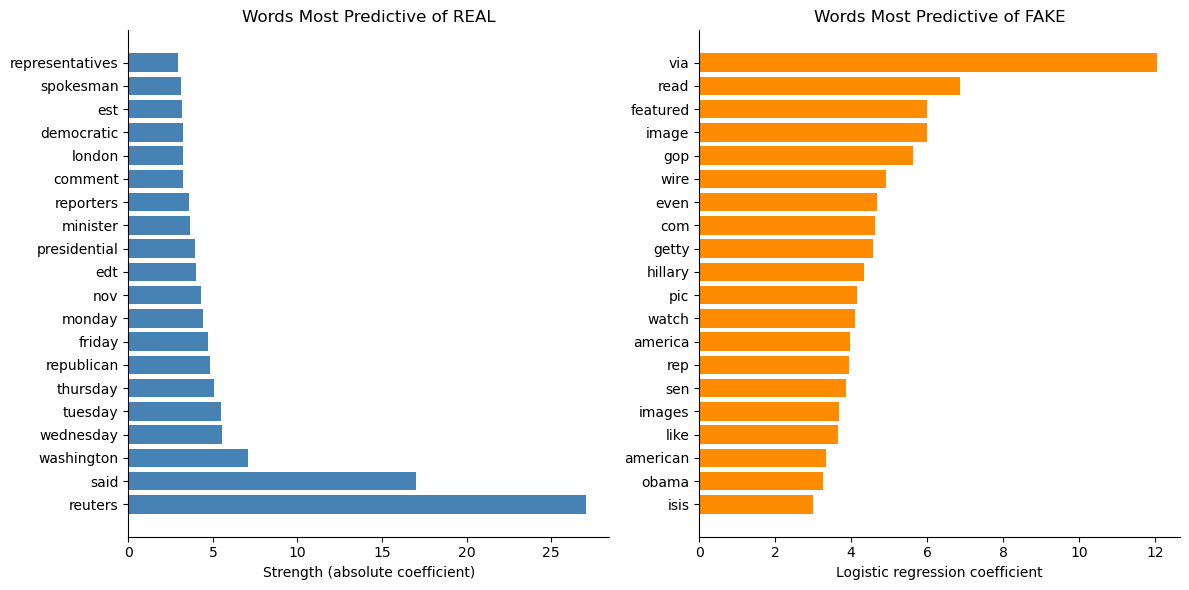

In [30]:
# Plot top fake vs real words (coefficients)

fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].barh(top_real_words, -top_real_coefs, color="steelblue")
ax[0].set_title("Words Most Predictive of REAL")
ax[0].set_xlabel("Strength (absolute coefficient)")

ax[1].barh(top_fake_words, top_fake_coefs, color="darkorange")
ax[1].set_title("Words Most Predictive of FAKE")
ax[1].set_xlabel("Logistic regression coefficient")

plt.tight_layout()
sns.despine(ax=ax[0])
sns.despine(ax=ax[1])

savefig(plt.gcf(), 'figure10_feature_importance')

plt.show()